# Bootstrapping for each replicate

## Data analysis: Linear model fit and volume corrected moments

In [2]:
using Random, Plots, Distributions, StatsBase, DataFrames, CSV, Plots.PlotMeasures

In [68]:
df = DataFrame(CSV.File("./mad1WTGFP/FISH_toShare_NoTSlabel_celldata_long_220620_simple_woMad3Outlier_withColDescription.csv"));

In [69]:
names(df);

In [70]:
df = df[:,[:gene,:NucleiCount,:Compartment,:CountMethod,:RNAperCell,:Cell_Length_um]];

In [71]:
genes

10-element Vector{String31}:
 "cdc13endog"
 "mad1endog"
 "rpb1endog"
 "mad1WTymEGFP"
 "mad2WTymEGFP"
 "bub1WTymEGFP"
 "mad3WTymEGFP"
 "sep1WTymEGFP-hph"
 "SPAC27D709cWTymEGFP-hph"
 "SPAC2H1001WTymEGFP-hph"

In [72]:
# filter NucleiCount = 1
dfa = subset(df,:NucleiCount => n -> n.==1)
# make cyto and nuc table separately.
dfcyto = subset(dfa, :Compartment=>c->c.=="Cytoplasm")
dfnuc = subset(dfa, :Compartment=>c->c.=="Nucleus")
# separate the 7 different genes
dfsN = []; dfsC = [];
genes = unique(dfa[!,:gene])
# add each to the vectors
for i in 1:10
    dftempN = subset(dfnuc, :gene=>S->S.==genes[i])
    dftempC = subset(dfcyto, :gene=>S->S.==genes[i])
    push!(dfsN,dftempN)
    push!(dfsC,dftempC)
end

In [73]:
dfsC = dfsC[[2,3,4,5,6,7,8]] # don't want cdc or SPACs
dfsN = dfsN[[2,3,4,5,6,7,8]] # don't want cdc or SPACs

7-element Vector{Any}:
 4146×6 DataFrame
  Row │ gene       NucleiCount  Compartment  CountMethod     RNAperCell  Cell_ ⋯
      │ String31   Int64        String15     String15        Float64     Float ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ mad1endog            1  Nucleus      SpotCount          0.0            ⋯
    2 │ mad1endog            1  Nucleus      IntensityCount     0.0
    3 │ mad1endog            1  Nucleus      HybridCount        0.0
    4 │ mad1endog            1  Nucleus      SpotCount          0.0
    5 │ mad1endog            1  Nucleus      IntensityCount     0.0            ⋯
    6 │ mad1endog            1  Nucleus      HybridCount        0.0
    7 │ mad1endog            1  Nucleus      SpotCount          0.0
    8 │ mad1endog            1  Nucleus      IntensityCount     0.0
    9 │ mad1endog            1  Nucleus      HybridCount        0.0            ⋯
   10 │ mad1endog            1  Nucleus      SpotCount          1

If the moments I find differ from this then I know there's an issue! Let's collect the columns corresponding to the nuclear and cytoplasmic volumes and **counts** respectively.

In [74]:
names(dfsC[1])

6-element Vector{String}:
 "gene"
 "NucleiCount"
 "Compartment"
 "CountMethod"
 "RNAperCell"
 "Cell_Length_um"

In [75]:
n_vols = [dfsN[i][!,:Cell_Length_um] for i in 1:length(dfsN)]
c_vols = [dfsC[i][!,:Cell_Length_um] for i in 1:length(dfsN)]
n_ints = [dfsN[i][!,:RNAperCell] for i in 1:length(dfsN)]
c_ints = [dfsC[i][!,:RNAperCell] for i in 1:length(dfsN)];

In [76]:
Ns = [length(c_ints[i]) for i in 1:length(dfsN)]

7-element Vector{Int64}:
 4146
 4275
 6465
 9192
 3426
 7980
 1767

For the linear model fits we use the Julia package GLM. This is a very convenient and fast way to construct linear models.

In [77]:
using GLM

Perform the linear model fits. Note in the below that our fitting parameters are stored in `npar` and `cpar` in the order `[intercept, gradient]`.

In [78]:
nlms = [lm(@formula(RNAperCell ~ Cell_Length_um), dfsN[i]) for i in 1:length(dfsN)]
npars = [coef(nlms[i]) for i in 1:length(dfsN)]
cs = hcat(npars...)[1,:]; ds = hcat(npars...)[2,:]
clms = [lm(@formula(RNAperCell ~ Cell_Length_um), dfsC[i]) for i in 1:length(dfsN)]
cpars = [coef(clms[i]) for i in 1:length(dfsN)]
as = hcat(cpars...)[1,:]; bs = hcat(cpars...)[2,:]

7-element Vector{Float64}:
 0.3027547144895288
 1.862936344101668
 0.4486839874995193
 0.4733008577390787
 0.3872917294645617
 0.5636688403707902
 0.33229267946068464

A quick look at the linear model fit itself will tell us some properties of the fit.

In [79]:
clms[1]

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

RNAperCell ~ 1 + Cell_Length_um

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)     -1.04726    0.0966759  -10.83    <1e-26  -1.23679   -0.85772
Cell_Length_um   0.302755   0.0104471   28.98    <1e-99   0.282273   0.323237
─────────────────────────────────────────────────────────────────────────────

Now, to construct the volume corrected moments we first need to know the mean values for the volumes and intensities. Collect these from the data.

In [80]:
n_vol_avgs = [mean(n_vols[i]) for i in 1:length(dfsN)]
c_vol_avgs = [mean(c_vols[i]) for i in 1:length(dfsN)]
n_avgs = [mean(n_ints[i]) for i in 1:length(dfsN)]
c_avgs = [mean(c_ints[i]) for i in 1:length(dfsN)]

7-element Vector{Float64}:
  1.7151718625745296
 17.610967268107835
  2.818037297496365
  2.853951370509465
  4.341669328347927
  3.471709988317795
  5.38877324092077

Note that even the means of the cytoplasmic can vary quite significantly between the replicates. As can the observed mean cell volumes in each experiment.

We know theoretically that to first order volume corrections to the means are nil. Let's just clarify this.

In [81]:
ds

7-element Vector{Float64}:
  0.023980893063671654
  0.07916482934427854
  0.03721835148155214
  0.05860329908418444
  0.014392613422049557
  0.025157783464598515
 -0.07699645804600715

In [82]:
vc_mean_ns = [cs[i] + n_vol_avgs[i]*ds[i] for i in 1:length(dfsN)]
vc_mean_cs = [as[i] + c_vol_avgs[i]*bs[i] for i in 1:length(dfsN)]
# vc_mean_cs = a + c_vol_avg*b

7-element Vector{Float64}:
  1.7151718625745302
 17.61096726810785
  2.8180372974963643
  2.853951370509466
  4.341669328347927
  3.4717099883177935
  5.388773240920772

In [83]:
μ20s = [moment(n_ints[i], 2, n_avgs[i]) for i in 1:length(dfsN)];
μ02s = [moment(c_ints[i], 2, c_avgs[i]) for i in 1:length(dfsN)];
μ2Ωs = [moment(n_vols[i], 2, n_vol_avgs[i]) for i in 1:length(dfsN)];

In [84]:
μ20s_i = [μ20s[i] - ds[i]^2 * μ20Ωs[i] for i in 1:length(dfsN)]
μ02s_i = [μ02s[i] - bs[i]^2 * μ02Ωs[i] for i in 1:length(dfsN)];

In [85]:
μ11s = [(sum(n_ints[i].*c_ints[i])/length(n_ints[i])) - n_avgs[i]*c_avgs[i] for i in 1:length(dfsN)]
μ11s_i = [μ11s[i] - ds[i]*bs[i] * μ2Ωs[i] for i in 1:length(dfsN)]

7-element Vector{Float64}:
 -0.10095622435350413
  0.04742611860024876
 -0.08693640723020321
 -0.259091630280019
 -0.14074223584828016
 -0.08221160809740848
 -0.1619172598908808

# Now for the bootstraps

In [89]:
function bootstrap_samps(n_pop,c_pop,v_pop,N)
    if length(n_pop)!=length(c_pop)
        return error("args must be the same length")
    end
    # make an array of all the indices
    all_inds = collect(1:1:length(n_pop))
    samps = [sort(sample(all_inds,N)) for i in 1:5000]
    n_samps = [n_pop[samps[i]] for i in 1:5000]
    c_samps = [c_pop[samps[i]] for i in 1:5000]
    v_samps = [v_pop[samps[i]] for i in 1:5000]
    cvs = zeros(5000)
    # for each bootstrapped sample we now need the vol corr moments.
    for j in 1:5000
        ns = n_samps[j]; cs = c_samps[j]; vs = v_samps[j];
        dftemp = DataFrame(vol=vs,n=ns,c=cs);
        nlm = lm(@formula(n ~ vol), dftemp);
        npars = coef(nlm); c = npars[1]; d = npars[2];
        clm = lm(@formula(c ~ vol), dftemp);
        cpars = coef(clm); a = cpars[1]; b = cpars[2];
        navg = mean(ns); cavg = mean(cs); vavg = mean(vs);
        μ2Ω = moment(vs, 2, vavg);
        μ11s = (sum(ns.*cs)/length(ns)) - navg*cavg;
        cvi = μ11s - d*b * μ2Ω
        cvs[j] = cvi;
    end
    return cvs
end
ti = 3
test = bootstrap_samps(n_ints[3],c_ints[3],n_vols[3],Ns[3]);

## Can now see the bootstrapped stds for everything

In [90]:
bssamps = [bootstrap_samps(n_ints[i],c_ints[i],n_vols[i],Ns[i]) for i in 1:length(n_ints)]

7-element Vector{Vector{Float64}}:
 [-0.08950982999387508, -0.09994604799368317, -0.10011619554089504, -0.09093169863247835, -0.09307110935983891, -0.09633602104692267, -0.09005073134534951, -0.09700923003147315, -0.09059171334707126, -0.09861181748342165  …  -0.07737622725038948, -0.08759033731543922, -0.0833191927038524, -0.1117831742584103, -0.09686480066849223, -0.10629347010466325, -0.09697831380595097, -0.0924848398275984, -0.09971368783250878, -0.11067677916954492]
 [-0.04531226436912372, 0.07189650712435203, -0.0029967777298349207, 0.09791493212713243, -0.027995165307633407, 0.02925145521458805, 0.1000203581259243, 0.0006719041725510855, -0.008905679436224112, 0.06914353300291493  …  -0.004686216300367141, 0.16735888142791433, 0.17320030078579357, 0.11492755728152304, 0.32536247635313553, -0.12020828569002895, 0.07074218981895164, -0.15553974545240523, 0.1548124282378303, 0.03351706450008568]
 [-0.07689423551284276, -0.09853835341108395, -0.09220076559104737, -0.087969060811092

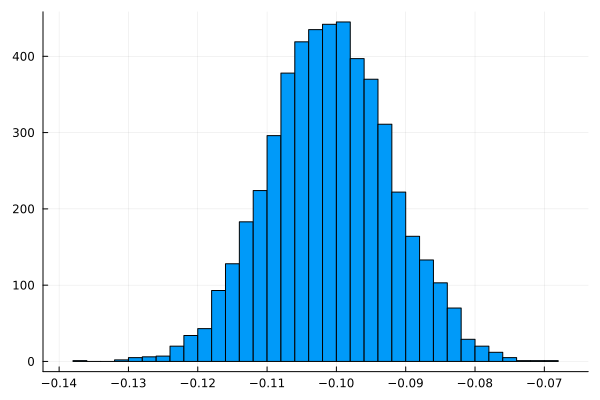

In [109]:
histogram(bssamps[1], legend = :none)

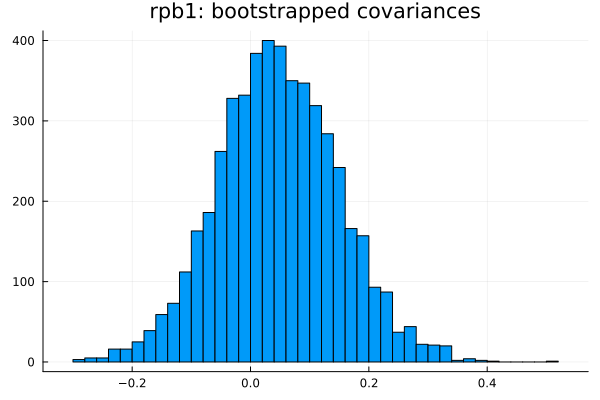

In [99]:
histogram(bssamps[2],title = "rpb1: bootstrapped covariances", legend = :none)

In [92]:
cvars = [var(bssamps[i]) for i in 1:length(n_ints)]
cvars_std = cvars.^(1/2)
c

7-element Vector{Float64}:
 0.008802494923478303
 0.10254842287215707
 0.008983421645554188
 0.014376744327739378
 0.021334371122142454
 0.010096614763545854
 0.0521347371765618

In [93]:
limits_cvars = [[μ11s_i[i]-cvars_std[i],μ11s_i[i],μ11s_i[i]+cvars_std[i]] for i in 1:length(n_ints)]

7-element Vector{Vector{Float64}}:
 [-0.10975871927698243, -0.10095622435350413, -0.09215372943002582]
 [-0.05512230427190831, 0.04742611860024876, 0.14997454147240583]
 [-0.0959198288757574, -0.08693640723020321, -0.07795298558464903]
 [-0.2734683746077584, -0.259091630280019, -0.24471488595227964]
 [-0.16207660697042262, -0.14074223584828016, -0.11940786472613771]
 [-0.09230822286095433, -0.08221160809740848, -0.07211499333386262]
 [-0.2140519970674426, -0.1619172598908808, -0.10978252271431899]

In [113]:
using StatsPlots

In [117]:
genes

10-element Vector{String31}:
 "cdc13endog"
 "mad1endog"
 "rpb1endog"
 "mad1WTymEGFP"
 "mad2WTymEGFP"
 "bub1WTymEGFP"
 "mad3WTymEGFP"
 "sep1WTymEGFP-hph"
 "SPAC27D709cWTymEGFP-hph"
 "SPAC2H1001WTymEGFP-hph"

In [128]:
sel_genes = genes[[2,3,4,5,6,7,8]];

In [132]:
all_df = DataFrame(mad1endong = bssamps[1], rpb1endog = bssamps[2], mad1WTymEGFP = bssamps[3],
    mad2WTymEGFP = bssamps[4], bub1WTymEGFP = bssamps[5], mad3WTymEGFP = bssamps[6],
    sep1WTymEGFP_hph = bssamps[7]);

In [136]:
all_df;

In [141]:
names(all_df)

7-element Vector{String}:
 "mad1endong"
 "rpb1endog"
 "mad1WTymEGFP"
 "mad2WTymEGFP"
 "bub1WTymEGFP"
 "mad3WTymEGFP"
 "sep1WTymEGFP_hph"

In [142]:
@df all_df violin(names(all_df))

LoadError: MethodError: no method matching default_bandwidth(::Vector{String})
[0mClosest candidates are:
[0m  default_bandwidth([91m::AbstractVector{T} where T<:Real[39m) at ~/.julia/packages/KernelDensity/bNBAQ/src/univariate.jl:32
[0m  default_bandwidth([91m::AbstractVector{T} where T<:Real[39m, [91m::Float64[39m) at ~/.julia/packages/KernelDensity/bNBAQ/src/univariate.jl:32
[0m  default_bandwidth([91m::Tuple{AbstractVector{T} where T<:Real, AbstractVector{T} where T<:Real}[39m) at ~/.julia/packages/KernelDensity/bNBAQ/src/bivariate.jl:41